In [1]:
### test_lgs_params.ipynb
### attempting to pull relevant parameters from science and weather data
### imports
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from astropy.io import fits
import lgs_metadata_compiler as md
import matplotlib.pyplot as plt
### ML algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
### Files and folders
root_dir = "/g/lu/data/gc" # root data directory
tables = "LGS_AO_data/steve_metadata/" # folder of data tables found in Steve's directory
meta_file = tables+"lgs_metadata2.fits" # test metadata table
# strehl and fwhm are labels, the rest are features
use_columns = ['strehl', 'fwhm', 'airmass', 'az', 'MASS', 'DIMM', 'wind_speed', 
               'wind_direction', 'temperature', 'relative_humidity', 'pressure']
y = use_columns[:2]
# guessing that DIMM is the DIMM seeing, MASS is the MASS seeing
# not really sure what units anything is in

In [3]:
# runs one random forest on features X and labels Y
def runRandomForest(X, Y, max_depth, n_estimators, max_features):
    map_errs = {}
    for col in Y.columns:
        y = Y[col] # extract one label column
        rf = RandomForestRegressor() # set up regressor
        # train-test split
        train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=rand_state)
        rf.fit(train_X, train_y) # fit model
        # get predictions
        rf_predictions = rf.predict(val_X)
        rf_mape = np.mean(np.abs((rf_predictions-val_y)/val_y))
        # save results as mean absolute percentage error
        map_errs[col] = rf_mape
    return map_errs

# params will be a dictionary of parameters to their ranges
# the ranges will list (start, stop, step) of each parameter
def nRandomForests(X, Y, n_runs, params):
    for p in params.keys:
        for j in range(p[0], p[1], p[2]):
            

SyntaxError: unexpected EOF while parsing (<ipython-input-3-7355cfb5506f>, line 22)

In [5]:
### Read info from Steve's metadata files
meta_data = Table.read(meta_file)
meta_data = meta_data.to_pandas() # convert to pandas
# Extract and clean relevant data
meta_clean = meta_data[use_columns].dropna()
meta_clean = meta_clean[meta_clean['fwhm']>0]
meta_clean # display

,strehl,fwhm,airmass,az,MASS,DIMM,wind_speed,wind_direction,temperature,relative_humidity,pressure
1643,0.331,59.09,1.55908,166.16518,0.06,0.40,0.514444,119.0,3.52,48.0,0.6182
1644,0.312,61.04,1.55759,166.39213,0.06,0.40,0.514444,119.0,3.52,48.0,0.6182
1645,0.316,57.67,1.55611,166.62168,0.06,0.45,0.514444,119.0,3.50,47.0,0.6182
1646,0.238,73.30,1.55465,166.85421,0.06,0.45,1.028889,119.0,3.47,47.0,0.6183
1647,0.269,65.81,1.55310,167.10523,0.06,0.42,0.514444,120.0,3.45,50.0,0.6183
...,...,...,...,...,...,...,...,...,...,...,...
5944,0.276,62.30,1.65075,203.03754,0.13,0.40,5.144444,68.0,2.82,11.0,0.6192
5945,0.315,60.11,1.65376,203.24851,0.13,0.40,4.630000,69.0,2.83,11.0,0.6192
5946,0.380,55.86,1.65690,203.46555,0.13,0.40,4.630000,69.0,2.83,11.0,0.6192
5947,0.333,59.27,1.65996,203.67566,0.13,0.40,4.115556,76.0,2.83,11.0,0.6192


In [6]:
# Extract y variables
Y = meta_clean[use_columns[:2]]
strehl = meta_clean['strehl']
fwhm = meta_clean['fwhm']

# Extract x variables
X = meta_clean[use_columns[2:]]

In [7]:
### Scale the data
# StandardScaler() subtracts the mean and divides by the standard deviation
# Very important for PCA to normalize for high-magnitude features
X_scaled = StandardScaler().fit_transform(X)
# (1-tolerance) is the amount (%) of variation we keep in our data
tolerance = 0.01

In [8]:
### Basic PCA - extracts features which have the most variation in the data
pca = PCA(1-tolerance)
pca.fit(X_scaled)
# View variance ratios
list(np.round(pca.explained_variance_ratio_, 2))
# 1. If the emphasis is on knowing what our features mean then this is not a great algorithm to use
# 2. We have so few features that we probably don't need to eliminate any if we use them as-is
# 3. The explained variance ratios are also all fairly small, so PCA isn't likely to help a lot

[0.25, 0.21, 0.17, 0.12, 0.08, 0.07, 0.05, 0.04, 0.01]

In [9]:
### Testing Random Forest Regressor
# This does not rely on feature scale, so we will leave it out
# This is basically identical to Kaggle's Intro ML exercise - just a proof of concept
rand_state = np.random.randint(100000)
percent_errors = {}
for col in Y.columns:
    y = Y[col] # extract one label column
    rf = RandomForestRegressor(random_state=rand_state) # set up regressor
    # train-test split
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=rand_state)
    rf.fit(train_X, train_y) # fit model
    # get predictions
    rf_predictions = rf.predict(val_X)
    percent_errors[col] = (rf_predictions-val_y)/val_y
    rf_mape = np.mean(np.abs(percent_errors[col]))
    # display results as mean absolute percentage error
    print("Mean Absolute Percentage Error for", col, ":", rf_mape*100,"%")

/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/envs/astroconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Percentage Error for strehl : 12.925744020806476 %
Mean Absolute Percentage Error for fwhm : 6.708759002298639 %


In [10]:
### Question: what does a fwhm value of -1 mean? This doesn't seem like a valid number,
### so I have excluded it in the clean data
### could do k-fold cross-validation instead of just one test set, but I want to make sure
### that I remember it correctly first and that I know how to use it in sklearn
### * also, it takes a really long time and we're already doing grid search :/

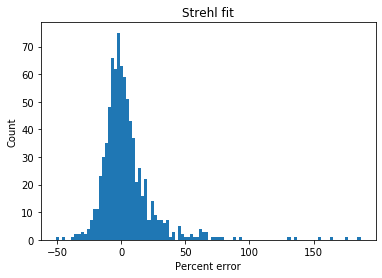

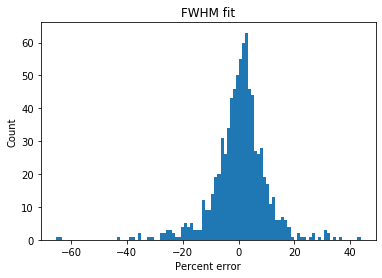

In [13]:
### Plots
# Strehl
plt.hist(100*percent_errors['strehl'], bins=100)
plt.title("Strehl fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("strehl_naive_rf_err.png")
plt.show()

# FWHM
plt.hist(100*percent_errors['fwhm'], bins=100)
plt.title("FWHM fit")
plt.xlabel("Percent error")
plt.ylabel("Count")
plt.savefig("fwhm_naive_rf_err.png")
plt.show()